In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression, Lasso
%matplotlib inline

In [55]:
def homog_across_area(
    parameters_path, barcode_matrix, cortical, shuffled, alpha_param=1, IT_only=False
):
    """
    Function to output a matrix of homogenous across areas, looking only at cortical samples
    Args:
        parameters_path
        barcode_matrix = pd.dataframe of barcodes
        cortical (bool): True if you want onkly to look at cortical regions
        shuffled (bool): True if you want to shuffle values in all columns as a negative control
        IT_only (bool): True if you want to look at only intratelencephalic neurons
    """
    parameters = fpf.load_parameters(directory=parameters_path)
    sequencing_directory = pathlib.Path(
        "".join(
            [
                parameters["PROCESSED_DIR"],
                "/",
                parameters["PROJECT"],
                "/",
                parameters["MOUSE"],
                "/Sequencing",
            ]
        )
    )
    # barcodes_across_sample = pd.read_pickle(sequencing_directory / "A1_barcodes.pkl")
    barcodes_across_sample = barcode_matrix
    lcm_directory = parameters["lcm_directory"]

    # sample_vol_and_regions = pd.read_pickle(''.join([lcm_directory, '/sample_vol_and_regions.pkl']))
    # sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    # sample_vol_and_regions['breakdown'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    # all_areas_unique_acronymn = np.unique(sample_vol_and_regions['regions'].explode().to_list())

    cortical_samples_columns = [
        int(col)
        for col in parameters["cortical_samples"]
        if col in barcodes_across_sample.columns
    ]
    # only look at cortical samples
    if cortical:
        barcodes_across_sample = barcodes_across_sample[cortical_samples_columns]
    barcodes_across_sample = barcodes_across_sample[
        barcodes_across_sample.astype(bool).sum(axis=1) > 0
    ]
    if IT_only:
        sample_vol_and_regions = pd.read_pickle(
            "".join([lcm_directory, "/sample_vol_and_regions.pkl"])
        )
        sample_vol_and_regions["regions"] = sample_vol_and_regions["regions"].apply(
            ast.literal_eval
        )
        roi_list = []
        index_list = []
        for index, row in sample_vol_and_regions.iterrows():
            if any(
                "IC" in region
                or "SCs" in region
                or "SCm" in region
                or "LGd" in region
                or "LGv" in region
                or "MGv" in region
                or "RT" in region
                or "LP" in region
                or "MGd" in region
                or "P," in region
                for region in row["regions"]
            ):
                if row["ROI Number"] not in parameters["cortical_samples"]:
                    index_list.append(index)
                    roi_list.append(row["ROI Number"])
        roi_list = [
            sample for sample in roi_list if sample in barcodes_across_sample.columns
        ]
        barcodes_across_sample = barcodes_across_sample[
            barcodes_across_sample[roi_list].sum(axis=1) == 0
        ]
    areas_only_grouped = fpf.get_area_volumes(
        barcode_table_cols=barcodes_across_sample.columns, lcm_directory=lcm_directory
    )
    # all_area_df = pd.DataFrame(index = barcodes_across_sample.columns, columns=all_areas_unique_acronymn)
    # for column in barcodes_across_sample.columns:
    #     #all_regions = sample_vol_and_regions_FIAA456d.loc[sample_vol_and_regions_FIAA456d.index[sample_vol_and_regions_FIAA456d['ROI Number'] == column].tolist(), 'Brain Regions'].explode().astype(int)
    #     index = sample_vol_and_regions[sample_vol_and_regions['ROI Number']==column].index
    #     reg = pd.DataFrame()
    #     reg['regions'] = [i for i in sample_vol_and_regions.loc[index, 'regions']][0]
    #     reg['fraction'] = [i for i in sample_vol_and_regions.loc[index, 'breakdown']][0]
    #     reg['vol_area'] = reg['fraction']*sample_vol_and_regions.loc[index, 'Volume (um^3)'].item()

    #     for _, row in reg.iterrows():
    #         all_area_df.loc[column, row['regions']] = row['vol_area']
    # group_areas = {'Contra': all_area_df.filter(like="Contra").columns}
    # areas_grouped = all_area_df.copy()
    # for group, columns in group_areas.items():
    #     areas_grouped[group] = areas_grouped.filter(items=columns).sum(axis=1)
    #     columns = [value for value in columns if value in all_area_df.columns]
    #     areas_grouped = areas_grouped.drop(columns, axis=1)
    # nontarget_list = ['fiber tracts', 'root']
    # nontarget_list = [value for value in nontarget_list if value in all_area_df.columns]
    # areas_only_grouped = areas_grouped.drop(nontarget_list, axis=1)
    # #create a dataframe of the fractions of each brain area contained within each sample
    # areas_only_grouped = areas_only_grouped.fillna(0)
    areas_only_grouped = areas_only_grouped.div(areas_only_grouped.sum(axis=0), axis=1)
    areas_matrix = areas_only_grouped.to_numpy()
    # total_frac = np.sum(areas_matrix, axis=1)
    # frac_matrix = areas_matrix/total_frac[:, np.newaxis]

    # barcodes_across_sample.fillna(0,inplace=True)
    barcodes_matrix = barcodes_across_sample.to_numpy()
    # barcodes_matrix[np.isnan(barcodes_matrix)] = 0
    if shuffled:
        barcodes_matrix = fpf.send_to_shuffle(barcodes=barcodes_matrix)
    total_projection_strength = np.sum(barcodes_matrix, axis=1)

    normalised_bc_matrix = barcodes_matrix / total_projection_strength[:, np.newaxis]
    normalised_bc_matrix = normalised_bc_matrix[
        total_projection_strength > 0, :
    ]  # needed as already removed barcodes with no projections but there are otherwise some nan values resulting from no projections in some barcodes after shuffling

    mdl = Lasso(fit_intercept=False, positive=True, alpha=alpha_param)
    mdl.fit(areas_matrix, normalised_bc_matrix.T)
    barcodes_homog = pd.DataFrame(mdl.coef_, columns=areas_only_grouped.columns)

    return barcodes_homog

In [102]:
#lets compare homog across area approach
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_area_areas_normalised'] = homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, alpha_param=1e-10)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    new_dict['homogenous_across_area_shuffle'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True)
    new_dict['homogenous_across_area_areas_normalised_shuffle'] = homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, alpha_param=1e-10)
    for alpha_val in [2, 1, 1e-1, 1e-3, 1e-7, 1e-10, 1e-20]:
        new_dict[f'homogenous_across_area_{alpha_val}'] = homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True, alpha_param=alpha_val)
        new_dict[f'homogenous_across_area_{alpha_val}_shuffled'] = homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True, alpha_param=alpha_val)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_area_areas_normalised', 'homogenous_across_area', 'homogenous_across_area_shuffle', 'homogenous_across_area_areas_normalised_shuffle']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

#first, how does normalising to zero change co-projection patterns?





In [67]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob

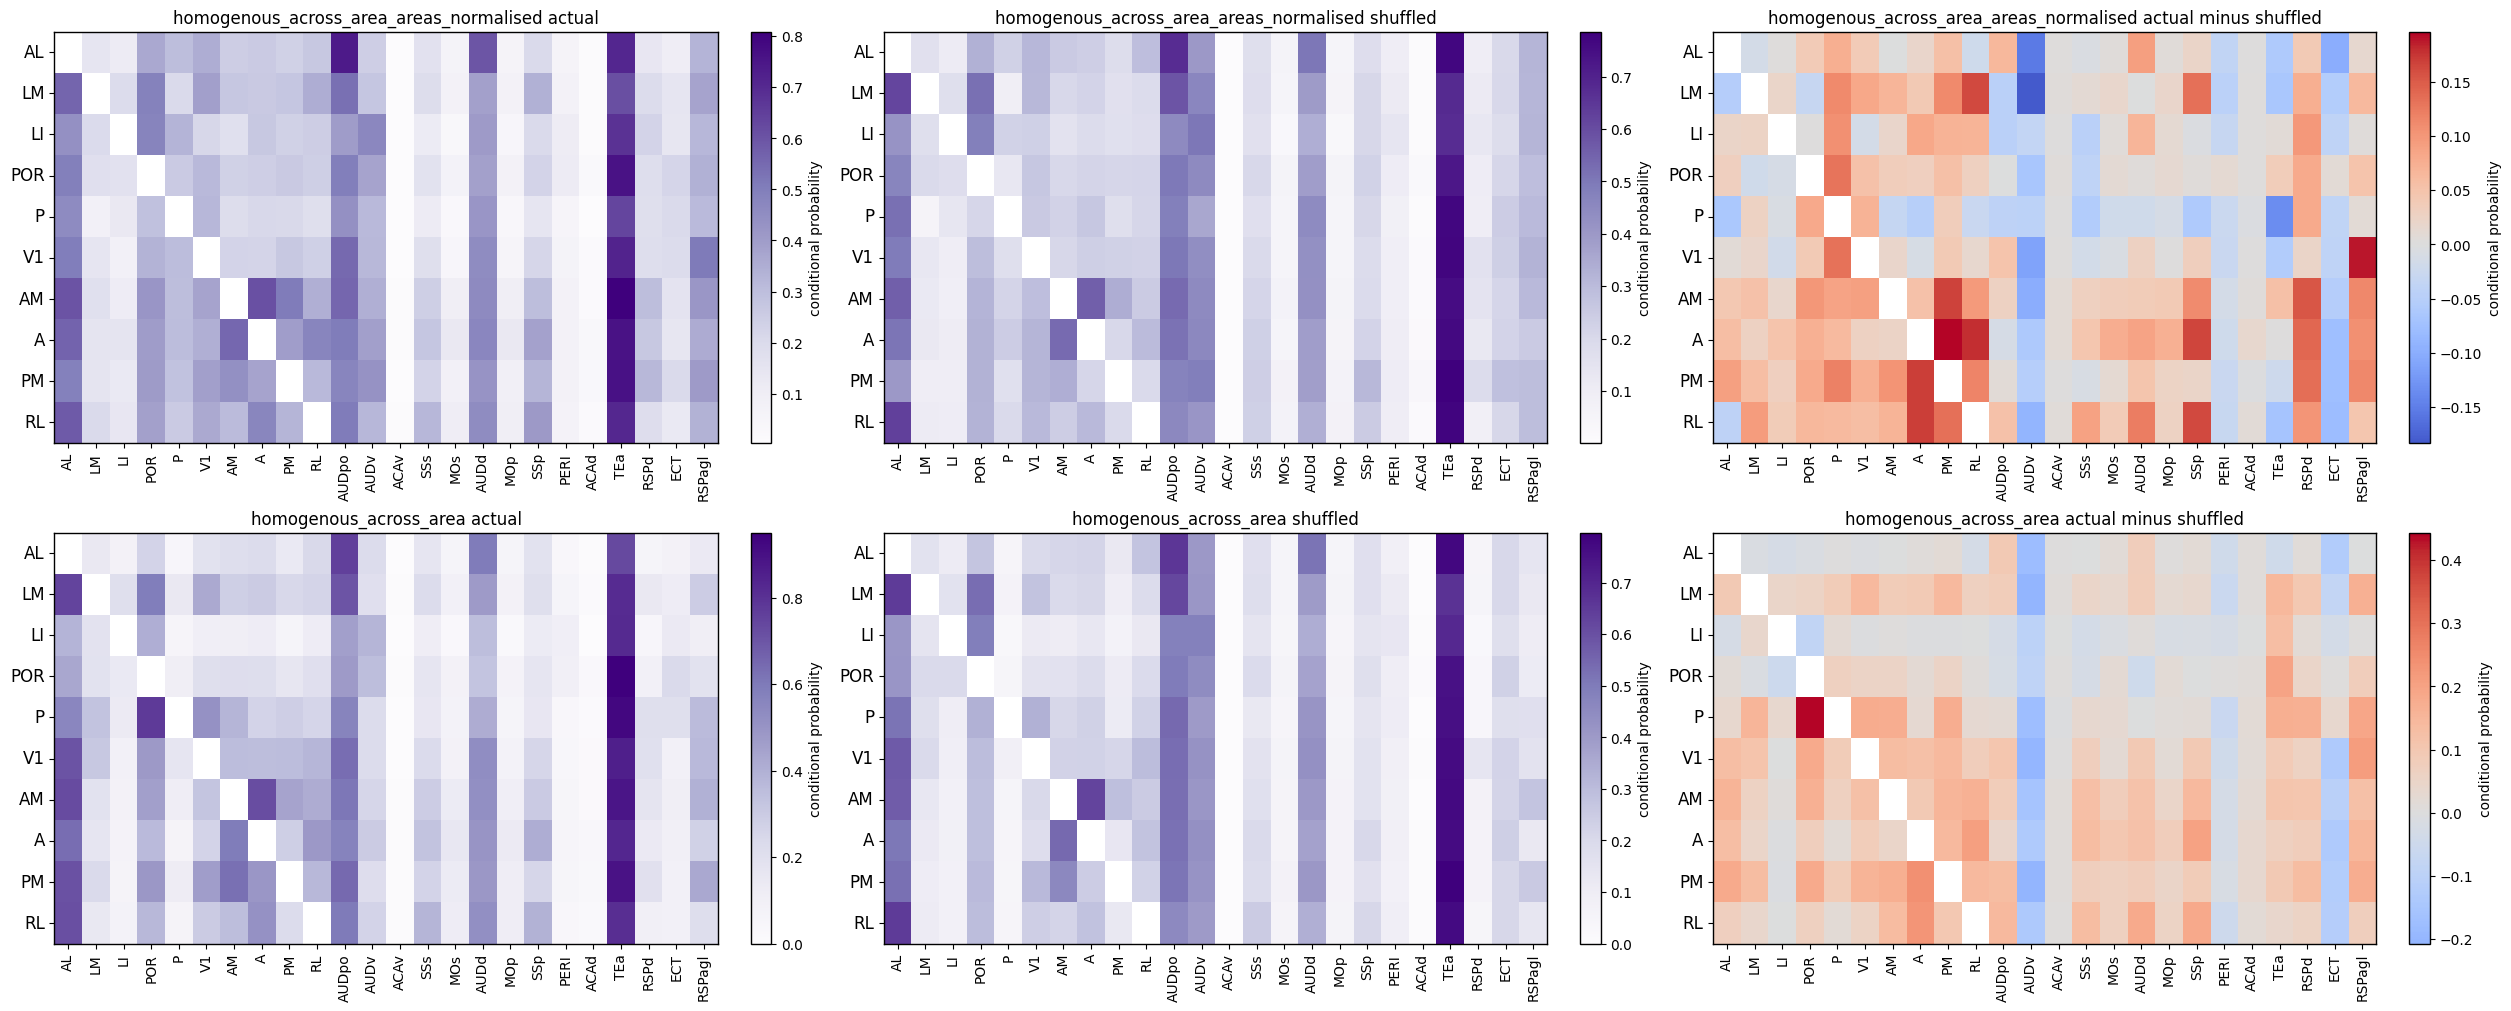

In [75]:

analysis_names =['homogenous_across_area_areas_normalised', 'homogenous_across_area']
fig, axs = plt.subplots(2, 3, figsize=(25, 10), constrained_layout=True)
cond_prob_dif_dict = {}
titles = ['actual', 'shuffled', 'actual minus shuffled']
for analysis_num, analysis_type in enumerate(analysis_names):
    matrix = all_combined[analysis_type].copy(deep=True)
    cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    all_cols = matrix.columns
    cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
    cols_reordered = [item for item in cols_reordered if item != 'AUDp']
    cols = [col for col in cols if col in all_cols]
    orig_df = get_cond_prob(matrix, columns=cols_reordered, index=cols_reordered)
    shuf_df = get_cond_prob(all_combined[f'{analysis_type}_shuffle'].copy(deep=True), columns=cols_reordered, index=cols_reordered)
    combined_dif = orig_df- shuf_df
    dfs = [orig_df, shuf_df, combined_dif]
    # cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    # all_cols = actual_data.columns
    # cols = [col for col in cols if col in all_cols]
    for number, title in enumerate(titles):
        data_to_use = dfs[number].copy(deep=True)
        shortened_data = data_to_use.loc[cols]
        if number>1:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='coolwarm', center=0,
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'})
        else:
            sb.heatmap(
                ax=axs[analysis_num, number], 
                data=fpf.convert_matrix_names(shortened_data), 
                cmap='Purples',
                xticklabels=True, 
                yticklabels=True, 
                cbar_kws={'label': 'conditional probability'}
            )
        axs[analysis_num, number].set_title(f'{analysis_type} {titles[number]}')
        axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
  
        for _, spine in axs[analysis_num, number].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
        cbar = axs[analysis_num, number].collections[0].colorbar
        cbar.outline.set_visible(True)
        cbar.outline.set_edgecolor('black')
        cbar.outline.set_linewidth(1)

In [106]:
matrix.sum(axis=1)

0       1.026400
1       0.708840
2       0.500737
3       1.247648
4       1.123237
          ...   
1105    0.056988
1106    0.056988
1107    2.077358
1108    1.508878
1109    1.116157
Length: 1110, dtype: float64

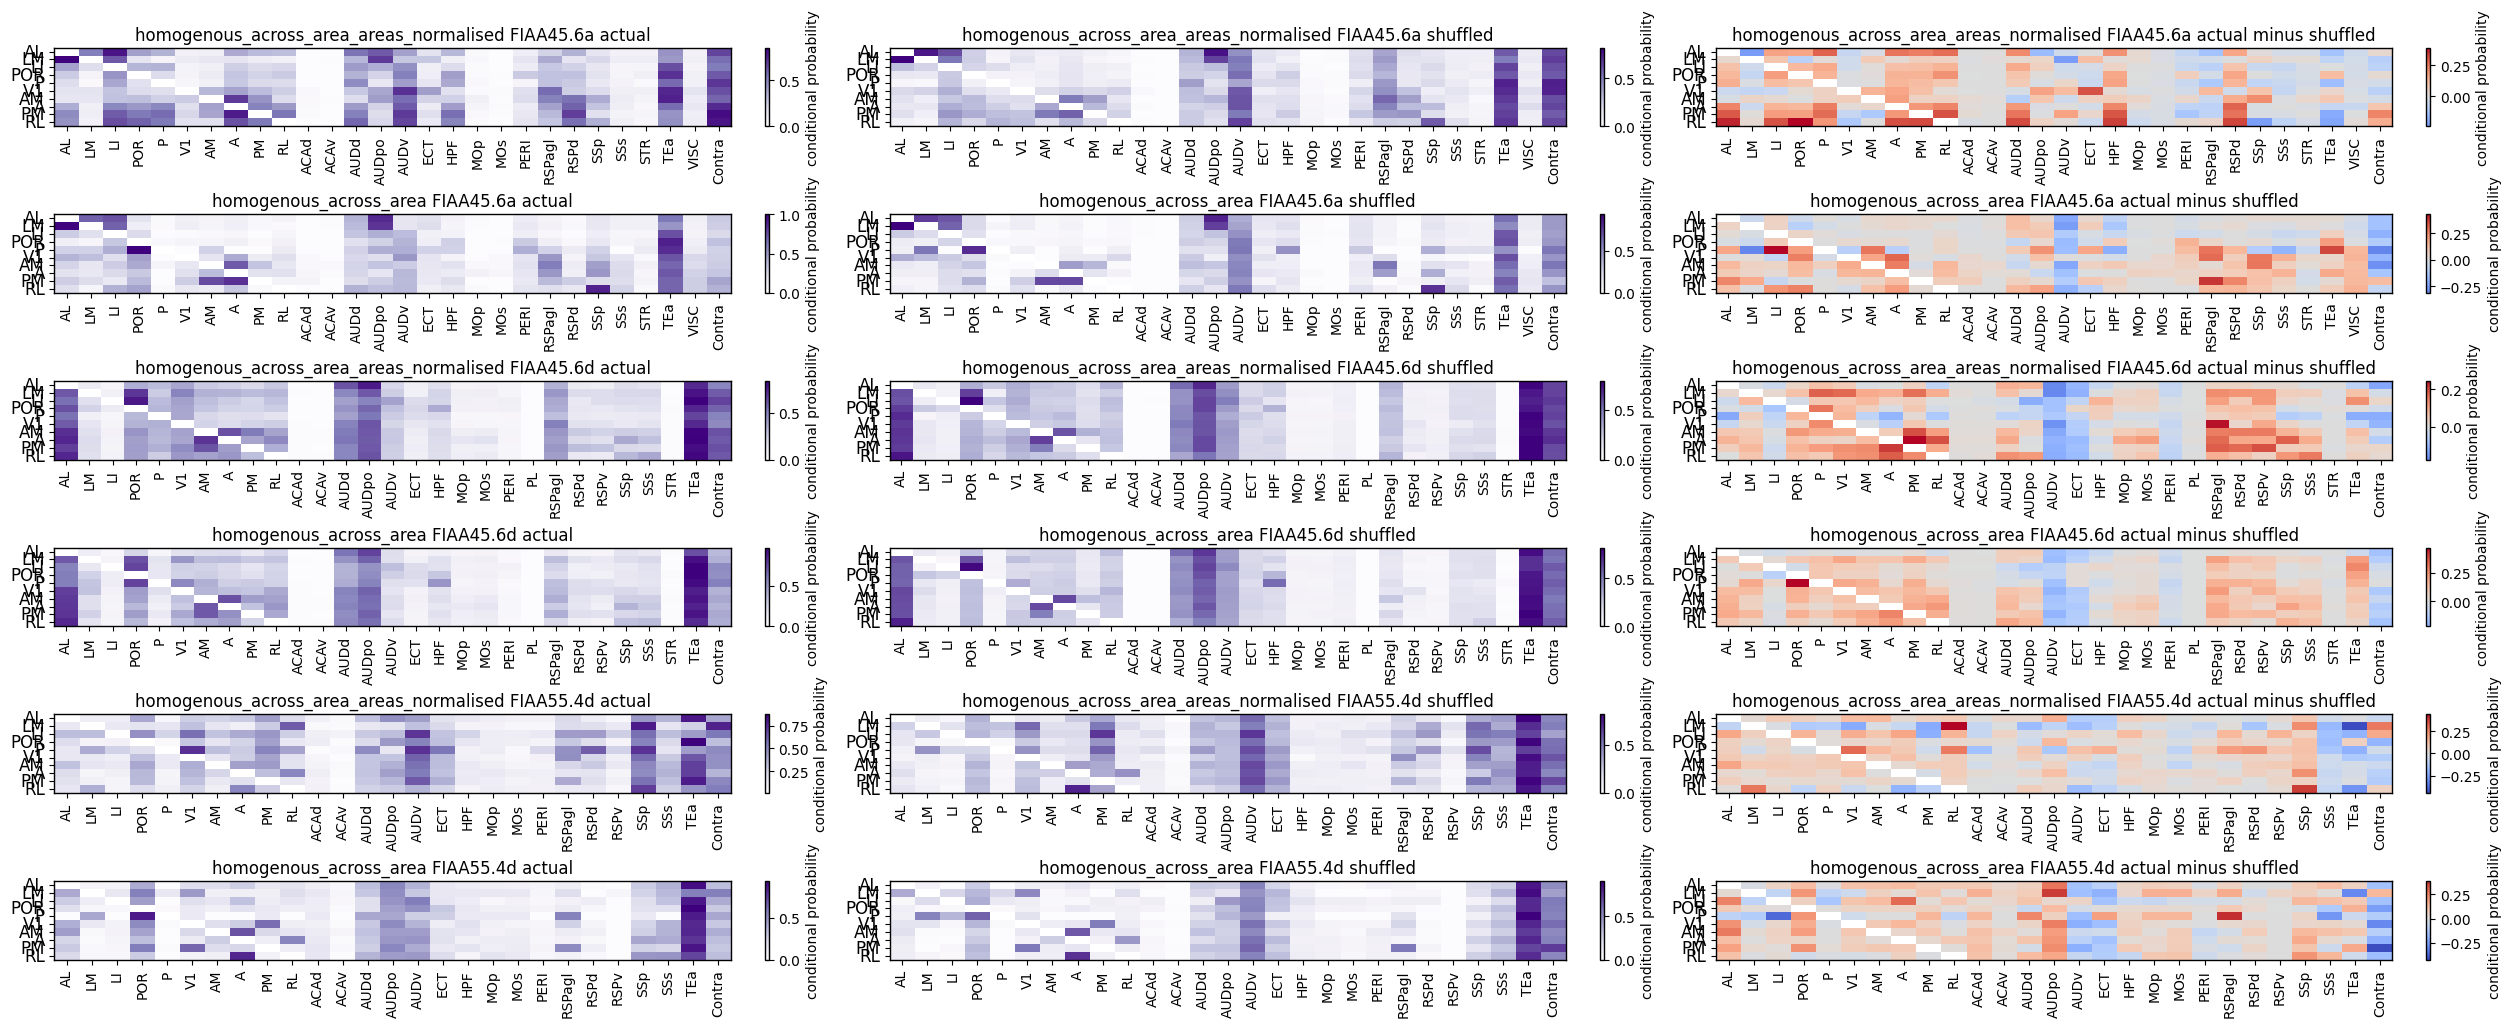

In [95]:

analysis_names =['homogenous_across_area_areas_normalised', 'homogenous_across_area']
fig, axs = plt.subplots(6, 3, figsize=(25, 10), constrained_layout=True)
cond_prob_dif_dict = {}
titles = ['actual', 'shuffled', 'actual minus shuffled']
analysis_num=0
for w, mouse in enumerate(mice):
    for num, analysis_type in enumerate(analysis_names):
        matrix = combined_dict[mouse][analysis_type].copy(deep=True)
        cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
        all_cols = matrix.columns
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        cols = [col for col in cols if col in all_cols]
        orig_df = get_cond_prob(matrix, columns=cols_reordered, index=cols_reordered)
        shuf_df = get_cond_prob(combined_dict[mouse][f'{analysis_type}_shuffle'].copy(deep=True), columns=cols_reordered, index=cols_reordered)
        combined_dif = orig_df- shuf_df
        dfs = [orig_df, shuf_df, combined_dif]
        # cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
        # all_cols = actual_data.columns
        # cols = [col for col in cols if col in all_cols]
        for number, title in enumerate(titles):
            data_to_use = dfs[number].copy(deep=True)
            shortened_data = data_to_use.loc[cols]
            if number>1:
                sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(shortened_data), 
                    cmap='coolwarm', center=0,
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'conditional probability'})
            else:
                sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(shortened_data), 
                    cmap='Purples',
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'conditional probability'}
                )
            axs[analysis_num, number].set_title(f'{analysis_type} {mouse} {titles[number]}')
            axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    
            for _, spine in axs[analysis_num, number].spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
            cbar = axs[analysis_num, number].collections[0].colorbar
            cbar.outline.set_visible(True)
            cbar.outline.set_edgecolor('black')
            cbar.outline.set_linewidth(1)
        analysis_num +=1

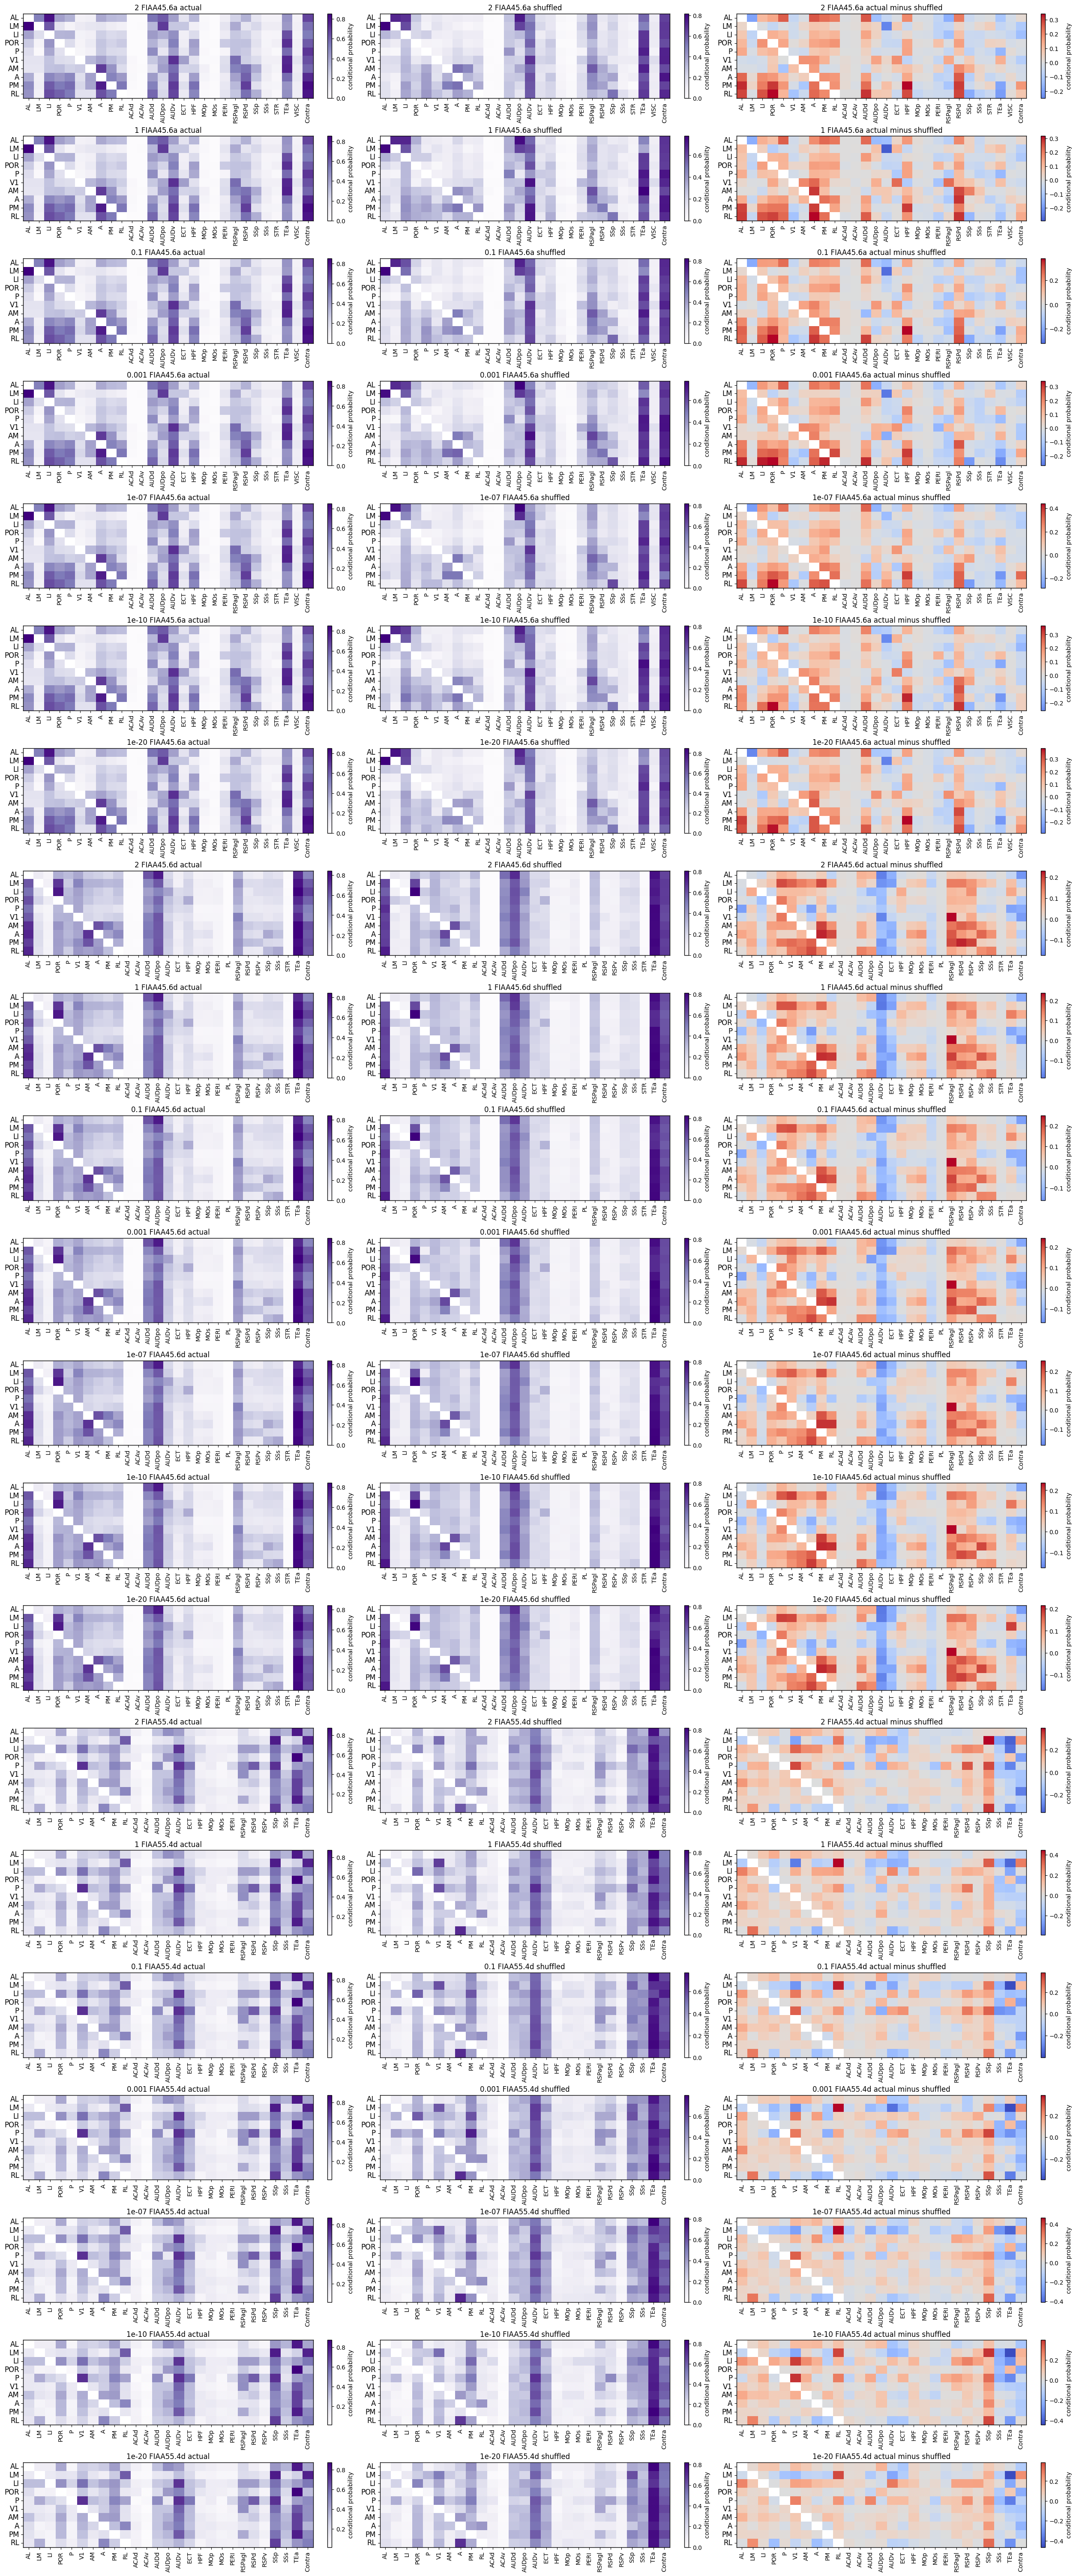

In [103]:
#f'homogenous_across_area_{alpha_val}_shuffled'

test_range = [2, 1, 1e-1, 1e-3, 1e-7, 1e-10, 1e-20]
analysis_names =['homogenous_across_area_areas_normalised', 'homogenous_across_area']
fig, axs = plt.subplots(21, 3, figsize=(25, 60), constrained_layout=True)
cond_prob_dif_dict = {}
titles = ['actual', 'shuffled', 'actual minus shuffled']
analysis_num=0
for w, mouse in enumerate(mice):
    for num, analysis_type in enumerate(test_range):
        matrix = combined_dict[mouse][f'homogenous_across_area_{analysis_type}'].copy(deep=True)
        cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
        all_cols = matrix.columns
        cols_reordered = [item for item in cols if item in all_cols] + [item for item in all_cols if item not in cols]
        cols_reordered = [item for item in cols_reordered if item != 'AUDp']
        cols = [col for col in cols if col in all_cols]
        orig_df = get_cond_prob(matrix, columns=cols_reordered, index=cols_reordered)
        shuf_df = get_cond_prob(combined_dict[mouse][f'homogenous_across_area_{analysis_type}_shuffled'].copy(deep=True), columns=cols_reordered, index=cols_reordered)
        combined_dif = orig_df- shuf_df
        dfs = [orig_df, shuf_df, combined_dif]
        # cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
        # all_cols = actual_data.columns
        # cols = [col for col in cols if col in all_cols]
        for number, title in enumerate(titles):
            data_to_use = dfs[number].copy(deep=True)
            shortened_data = data_to_use.loc[cols]
            if number>1:
                sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(shortened_data), 
                    cmap='coolwarm', center=0,
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'conditional probability'})
            else:
                sb.heatmap(
                    ax=axs[analysis_num, number], 
                    data=fpf.convert_matrix_names(shortened_data), 
                    cmap='Purples',
                    xticklabels=True, 
                    yticklabels=True, 
                    cbar_kws={'label': 'conditional probability'}
                )
            axs[analysis_num, number].set_title(f'{analysis_type} {mouse} {titles[number]}')
            axs[analysis_num, number].tick_params(axis='y', which='major', labelsize=12, rotation=0)
    
            for _, spine in axs[analysis_num, number].spines.items():
                spine.set_visible(True)
                spine.set_color('black')
                spine.set_linewidth(1)
            cbar = axs[analysis_num, number].collections[0].colorbar
            cbar.outline.set_visible(True)
            cbar.outline.set_edgecolor('black')
            cbar.outline.set_linewidth(1)
        analysis_num +=1